In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [30]:
!ls

adc.json     sample_data		test	  train
kaggle.json  sample_submission.csv.zip	test.zip  train.zip


In [0]:
#get shareable link from your csv file in gdrive
link = 'https://drive.google.com/open?id=1MmZS962wr2KQI2vEQbAWiEJ3exkYuso4'
_, id = link.split("=")

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('kaggle.json')  

In [32]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [33]:
!kaggle competitions download -c grasp-and-lift-eeg-detection

test.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
!unzip train.zip
!unzip test.zip

Archive:  train.zip
replace train/subj10_series1_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/subj10_series1_data.csv  
replace train/subj10_series1_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/subj10_series1_events.csv  
replace train/subj10_series2_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/subj10_series2_data.csv  
replace train/subj10_series2_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/subj10_series2_events.csv  
replace train/subj10_series3_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/subj10_series3_data.csv  
replace train/subj10_series3_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/subj10_series3_events.csv  
replace train/subj10_series4_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/subj10_series4_data.csv  
replace train/subj10_series4_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/

In [0]:

from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as auc,roc_curve
from scipy.interpolate import BSpline

# from radam import RAdam


In [0]:
USE_CUDA=1

In [0]:
def prepare_data_train(fname):
    """ read and prepare training data """
    data = pd.read_csv(fname)
    events_fname = fname.replace('_data','_events')
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels


scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    
    return X_prep
def data_preprocess_test(X):
    X_prep=scaler.transform(X)
    
    return X_prep

In [0]:
labels = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']


In [0]:
subjects=range(1,13)

In [0]:
def load_data(subjects,series):
  y_raw= []
  raw = []
  for subject in subjects:
    print("Loading from subject ",subject)
    
    for ser in series:
      fname ='train/subj%d_series%d_data.csv' % (subject,ser)
      # print(fname)
      data,labels=prepare_data_train(fname)
      raw.append(data)
      y_raw.append(labels)

    X = pd.concat(raw)
    y = pd.concat(y_raw)
      
    X =np.asarray(X.astype(float))
    y = np.asarray(y.astype(float))

  return X,y

In [0]:
train_series=[1,2,5,6,7,8]
test_series=[3,4]

In [0]:
X_train,y_train=load_data(subjects,series=train_series)
X_train=data_preprocess_train(X_train)
print(X_train.shape,y_train.shape)

Loading from subject  1
Loading from subject  2
Loading from subject  3
Loading from subject  4
Loading from subject  5
Loading from subject  6
Loading from subject  7
Loading from subject  8
Loading from subject  9
Loading from subject  10
Loading from subject  11
Loading from subject  12
(13239043, 32) (13239043, 6)


In [0]:
X_test,y_test=load_data(subjects,series=test_series)
X_test=data_preprocess_test(X_test)
print(X_test.shape,y_test.shape)

Loading from subject  1
Loading from subject  2
Loading from subject  3
Loading from subject  4
Loading from subject  5
Loading from subject  6
Loading from subject  7
Loading from subject  8
Loading from subject  9
Loading from subject  10
Loading from subject  11
Loading from subject  12
(4746711, 32) (4746711, 6)


In [0]:
# some parameteres for the model
num_features = 32
window_size = 1024
batch_size=2000

In [0]:
def get_batch(dataset,target, batch_size=2000, val=False, index=None):
    if val == False:
        index = random.randint(window_size, len(dataset) - 16 * batch_size)
        indexes = np.arange(index, index + 16*batch_size, 16)

    else:
        indexes = np.arange(index, index + batch_size)
    
    batch = np.zeros((batch_size, num_features, window_size//4))
    
    b = 0
    print(i)
    for i in indexes:
        
        start = i - window_size if i - window_size > 0 else 0
        
        tmp = dataset[start:i]
        batch[b,:,:] = tmp[::4].transpose()
        
        b += 1

    targets = target[indexes]
    return torch.DoubleTensor(batch), torch.DoubleTensor(targets) 

In [0]:

class convmodel(nn.Module):
  def __init__(self, drop=0.5):
    super().__init__()
    self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=0, stride=1)
    self.bn = nn.BatchNorm1d(64)
    self.pool = nn.MaxPool1d(2, stride=2)
    self.dropout1 = nn.Dropout(drop)
    self.conv = nn.Sequential(self.conv2, nn.ReLU(inplace=True), self.bn,self.pool, self.dropout1)
  def forward(self, x):
    x = self.conv(x)

    return x


In [0]:
class Combine(nn.Module):
    def __init__(self,out_classes):
        super(Combine, self).__init__()
        self.cnn = convmodel().double()
        self.rnn = nn.LSTM(input_size=127, hidden_size=64, num_layers=1,batch_first=True)
        self.linear = nn.Linear(64,out_classes)

    def forward(self, x):
      x = self.cnn(x)
      out, hidden=self.rnn(x)
      
      out = self.linear(out[:, -1, :])
      
      return torch.sigmoid(out)
        

In [0]:
model = Combine(6).double()
if USE_CUDA == 1:
    model = model.cuda()
optim = torch.optim.Adam(model.parameters(), lr=1e-3, eps=1e-10)

from torch.nn.modules.module import _addindent
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    return tmpstr

print(torch_summarize(model))

Combine (
  (cnn): convmodel(
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.5, inplace=False)
    (conv): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.5, inplace=False)
    )
  ), weights=((64, 32, 3), (64,), (64,), (64,)), parameters=6336
  (rnn): LSTM(127, 64, batch_first=True), weights=((256, 127), (256, 64), (256,), (256,)), parameters=49408
  (linear): Linear(in_features=64, out_features=6, bias=True), weights=((6, 64), (6,)), parameters=390
)


In [0]:
bs = batch_size
def train(traindata,y_train, epochs, printevery=100, shuffle=True):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(traindata)//bs):
            optim.zero_grad()
            x, y = get_batch(traindata,y_train)
            if USE_CUDA == 1:
                x = Variable(x).cuda()
                y = Variable(y).cuda()
            preds = model(x)
            loss = F.binary_cross_entropy(preds.view(-1), y.view(-1))
            loss.backward()
            total_loss += loss.item()
            optim.step()
            if (i + 1) % printevery == 0:
                print("epoch: %d, iter %d/%d, loss %.4f"%(epoch + 1, i + 1, len(traindata)//2000, total_loss/printevery))
                total_loss = 0

In [0]:
train(X_train,y_train,3)

6619
epoch: 1, iter 100/6619, loss 0.1166
epoch: 1, iter 200/6619, loss 0.1125
epoch: 1, iter 300/6619, loss 0.1119
epoch: 1, iter 400/6619, loss 0.1134
epoch: 1, iter 500/6619, loss 0.1018
epoch: 1, iter 600/6619, loss 0.1048
epoch: 1, iter 700/6619, loss 0.1068
epoch: 1, iter 800/6619, loss 0.1020
epoch: 1, iter 900/6619, loss 0.1004
epoch: 1, iter 1000/6619, loss 0.1039
epoch: 1, iter 1100/6619, loss 0.0962
epoch: 1, iter 1200/6619, loss 0.0992
epoch: 1, iter 1300/6619, loss 0.0988
epoch: 1, iter 1400/6619, loss 0.0989
epoch: 1, iter 1500/6619, loss 0.1025
epoch: 1, iter 1600/6619, loss 0.0958
epoch: 1, iter 1700/6619, loss 0.0978
epoch: 1, iter 1800/6619, loss 0.0950
epoch: 1, iter 1900/6619, loss 0.1021
epoch: 1, iter 2000/6619, loss 0.0965
epoch: 1, iter 2100/6619, loss 0.0911
epoch: 1, iter 2200/6619, loss 0.0995
epoch: 1, iter 2300/6619, loss 0.0934
epoch: 1, iter 2400/6619, loss 0.0995
epoch: 1, iter 2500/6619, loss 0.0948
epoch: 1, iter 2600/6619, loss 0.0941
epoch: 1, iter 2

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Flask_app'

Mounted at /content/gdrive


In [0]:
import os
os.chdir(base_dir)
PATH = base_dir + "/cnnlstm.pt"
torch.save(model.state_dict(), PATH)

In [0]:
model = torch.load(PATH)
print(model)

OrderedDict([('cnn.conv2.weight', tensor([[[ 7.1550e-02, -4.0758e-02, -4.5940e-02],
         [ 2.3009e-01,  2.5675e-01,  1.8679e-01],
         [-2.8994e-01, -2.4781e-01, -3.0784e-01],
         ...,
         [ 2.3977e-01,  4.5957e-02,  3.9919e-01],
         [ 4.1067e-01,  9.5622e-02,  6.3195e-01],
         [-4.5758e-02, -3.2675e-01, -4.2128e-03]],

        [[ 1.7922e-02,  4.9621e-02, -1.1378e-02],
         [-3.9477e-02, -5.8473e-02, -1.1562e-02],
         [ 1.1609e-01,  2.0637e-01,  2.0763e-01],
         ...,
         [ 5.8822e-01,  3.4015e-01,  4.6907e-01],
         [ 1.9971e-01, -6.5062e-02, -6.0119e-02],
         [ 1.7533e-01,  3.1653e-03,  6.8844e-02]],

        [[ 9.5071e-02,  2.3655e-01,  3.6629e-02],
         [-1.8290e-01, -2.4148e-02, -1.6150e-02],
         [ 1.9733e-01,  2.5213e-01,  2.7244e-01],
         ...,
         [-5.1258e-02, -8.2455e-02, -1.1092e-01],
         [ 2.0200e-02, -3.0310e-02, -1.5393e-01],
         [-5.3534e-02,  1.2916e-01, -1.1598e-01]],

        ...,

    

In [0]:
def getPredictions(data,y_test):
    model.eval()
    p = []
    res = []
    i = window_size
    bs = 2000
    while i < len(data):
        if i + bs > len(data):
            bs = len(data) - i
        x, y = get_batch(data,y_test, bs, index=i, val=True)
        x = (x)
        x = x.cuda()
        y = y
        preds = model(x)
        preds = preds.squeeze(1)
        p.append(np.array(preds.cpu().data))
        res.append(np.array(y.data))
        i += bs
    preds = p[0]
    for i in p[1:]:
        preds = np.vstack((preds,i))
    targs = res[0]
    for i in res[1:]:
        targs = np.vstack((targs, i))
    return preds, targs

def valscore(preds, targs):
    aucs = [auc(targs[:, j], preds[:, j]) for j in range(6)]
    total_loss = np.mean(aucs)
    return total_loss

In [0]:
val_preds, val_targs=getPredictions(X_test,y_test)
print("AUC score on testing set :",valscore(val_preds, val_targs))

AUC score on test set : 0.8943254983715556


In [0]:
train_preds, train_targs = getPredictions(X_train,y_train)
print("AUC score on training set :",valscore(train_preds, train_targs))

AUC score on training set : 0.9001580329209894


In [0]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [0]:
preds=np.where(val_preds>0.3,1,0)
acc_score=[]
for j in range(6):
  acc_score.append(accuracy_score(val_targs[:, j],preds[:, j]))
print("Accurecy Score :",np.mean(acc_score))


Accurecy Score : 0.9674371697922767


In [0]:
for j in range(6):
  print("CM on {} class".format(labels[j]))
  print(confusion_matrix(val_targs[:, j],preds[:, j]))


CM on HandStart class
[[4614950   15537]
 [ 103571   11629]]
CM on FirstDigitTouch class
[[4547906   82581]
 [  72659   42541]]
CM on BothStartLoadPhase class
[[4563943   66544]
 [  74681   40519]]
CM on LiftOff class
[[4562438   68049]
 [  83904   31296]]
CM on Replace class
[[4514819  115668]
 [  60698   54502]]
CM on BothReleased class
[[4518329  112158]
 [  71148   44052]]


In [0]:
def plot_roc_curve(fpr, tpr,classname):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve on {} class'.format(classname))
    plt.legend()
    plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


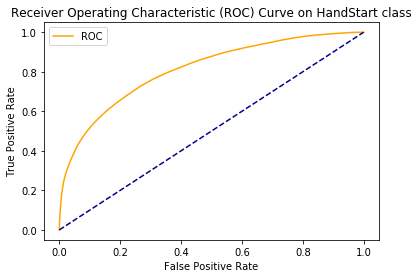

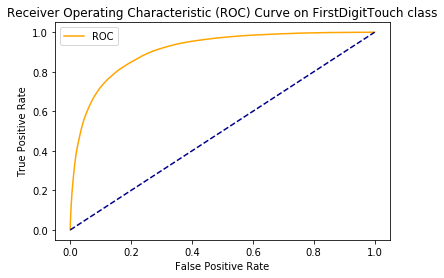

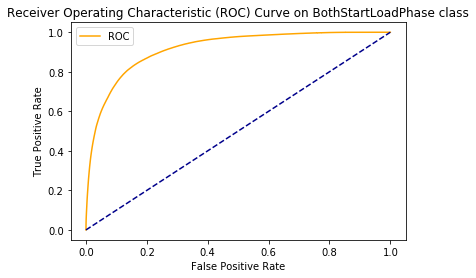

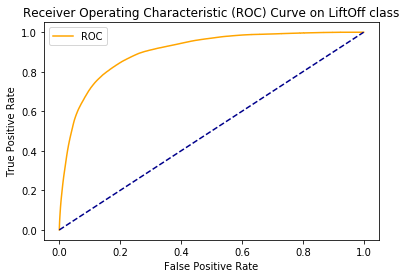

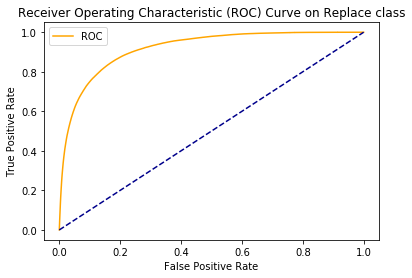

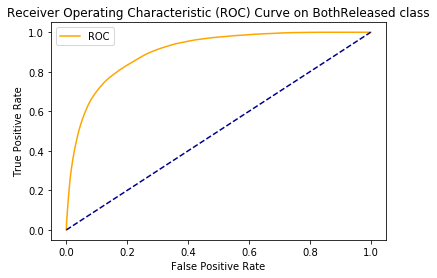

In [0]:
for j in range(6):
    fpr, tpr, thresholds = roc_curve(val_targs[:, j], val_preds[:, j])
    plot_roc_curve(fpr, tpr,str(labels[j]))

In [0]:
def show_whole_series(f=1, th=0.3):
    ps = np.where(val_preds[:,f] > th)
    true = np.where(val_targs[:,f] == 1)
    fig = plt.figure(figsize=[15,1])
    ax1 = fig.add_subplot(1,1,1)
    ax1.scatter(ps[0]/500, ['Prediction']*len(ps[0]))
    ax1.scatter(true[0]/500, ['True']*len(true[0]))

In [0]:
#Train individuals
def train_individuals(subject,epoche):
  subjects=[subject]
  X_train,y_train=load_data(subjects,series =[1,2,5,6,7,8])
  X_train=data_preprocess_train(X_train)
  
  X_test,y_test=load_data(subjects,series=[3,4])
  X_test=data_preprocess_test(X_test)

  train(X_train,y_train,epoche)
  val_preds, val_targs=getPredictions(X_test,y_test)
  print("AUC score :",valscore(val_preds, val_targs))
  show_whole_series()



Loading from subject  3
Loading from subject  3
epoch: 1, iter 100/455, loss 0.0725
epoch: 1, iter 200/455, loss 0.0674
epoch: 1, iter 300/455, loss 0.0695
epoch: 1, iter 400/455, loss 0.0659
AUC score : 0.8889055266724378


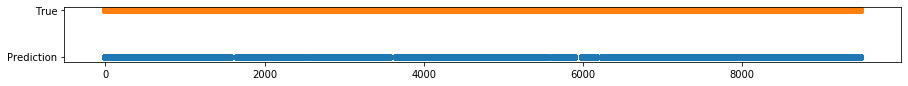

In [0]:
#train test on 3rd series
train_individuals(3,epoche=1)

In [0]:
#train test on individual series

# all_subjects=range(1,13)
# for i in all_subjects:
#   train_individuals(i)